<a href="https://colab.research.google.com/github/riesacassano/fMRI_piano/blob/master/ryc_101521_WvA_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script implements the within vs across measure, first with simulated data and then with example real data. The WvA calculation is adapted from Jamal's script [hmm_K_sweep_paper_no_srm.py](https://github.com/jamalw/music_event_structures_bucket/blob/master/hmm_K_sweep_paper_no_srm.py). Data simulation is borrowed from [BrainIAK tutorial 12](https://brainiak.org/tutorials/12-hmm/). 

In [ ]:
!pip install brainiak

In [2]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from brainiak.eventseg.event import EventSegment
import matplotlib.pyplot as plt

Generate simulated data with known number of events.

In [3]:
def generate_event_labels(T, K, length_std):
    event_labels = np.zeros(T, dtype=int)
    start_TR = 0
    for e in range(K - 1):
        length = round(
            ((T - start_TR) / (K - e)) * (1 + length_std * np.random.randn()))
        length = min(max(length, 1), T - start_TR - (K - e))
        event_labels[start_TR:(start_TR + length)] = e
        start_TR = start_TR + length
    event_labels[start_TR:] = K - 1

    return event_labels


def generate_data(V, T, event_labels, event_means, noise_std):
    simul_data = np.empty((V, T))
    for t in range(T):
        simul_data[:, t] = stats.multivariate_normal.rvs(
            event_means[:, event_labels[t]], cov=noise_std, size=1)

    simul_data = stats.zscore(simul_data, axis=1, ddof=1)
    return simul_data

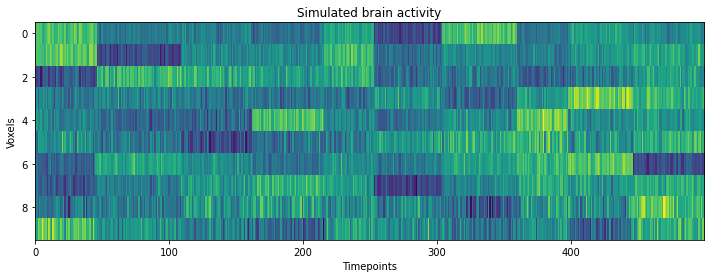

In [4]:
# Parameters for creating small simulated datasets
V = 10 # number of voxels
K = 10 # number of events
T = 500 # Time points

# Generate the first dataset
np.random.seed(1)
event_means = np.random.randn(V, K)
event_labels = generate_event_labels(T, K, 0.2)
D = generate_data(V, T, event_labels, event_means, 1/4)

# Check the data
f, ax = plt.subplots(1,1, figsize=(12, 4))
ax.imshow(D, interpolation='nearest', cmap='viridis', aspect='auto')
ax.set_ylabel('Voxels')
ax.set_title('Simulated brain activity')
ax.set_xlabel('Timepoints');

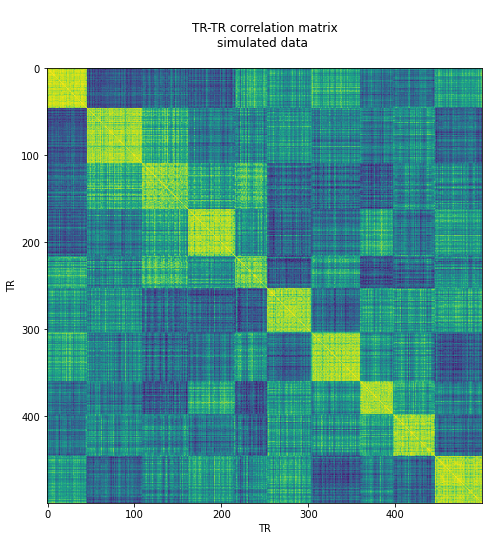

In [5]:
# Show the timepoint by timepoint correlation matrix
f, ax = plt.subplots(1,1, figsize = (10,8))
ax.imshow(np.corrcoef(D.T), cmap='viridis')
title_text = '''
TR-TR correlation matrix
simulated data 
'''
ax.set_title(title_text)
ax.set_xlabel('TR')
ax.set_ylabel('TR');

In [6]:
print(D.shape)

(10, 500)


In [7]:
# Find the events in this dataset using ground truth K
ev = EventSegment(K)
ev.fit(D.T)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10, n_iter=500, split_merge=False,
             split_merge_proposals=1,
             step_var=<function EventSegment._default_var_schedule at 0x7f37ea59d5f0>)

In [8]:
print(len(ev.segments_[0]))
print(ev.segments_[0][0])

500
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


For each time point, `segments_` indicates the probability that that time point is in each event. For time point 0, the model determines p = 1 that this time point is in the first event.

Taking the argmax of `segments_` essentially gives you the model's predictions of which event each time point is in.

In [9]:
events = np.argmax(ev.segments_[0],axis=1)
print(events)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

In [12]:
max_event_length = stats.mode(events)[1][0]
print(max_event_length)

63


The longest event is 63 TRs.

In [20]:
unique, counts = np.unique(events,return_counts=True)
print(counts)

[46 63 53 54 37 51 56 38 48 54]


In [10]:
# Compute timepoint by timepoint correlation matrix 
cc = np.corrcoef(D.T)
# Should be a time by time correlation matrix
print(cc.shape)

(500, 500)


In [13]:
# Create a mask to only look at values up to max_event_length
local_mask = np.zeros(cc.shape, dtype=bool)
for k in range(1,max_event_length):
  local_mask[np.diag(np.ones(cc.shape[0]-k, dtype=bool), k)] = True

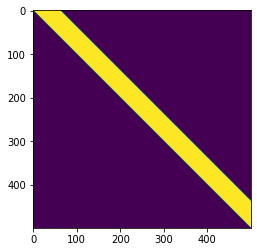

In [14]:
# Convert the mask to 0s and 1s to visualize
local_mask.astype('int')
plt.imshow(local_mask)
# Convert it back to bool for next steps
local_mask.astype('bool');

In [15]:
# Compute within vs across boundary correlations
same_event = events[:,np.newaxis] == events
print(same_event)

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


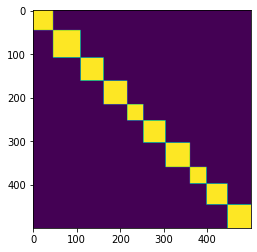

In [16]:
same_event.astype('int')
plt.imshow(same_event)
same_event.astype('bool');

In [17]:
print(same_event*local_mask)

[[False  True  True ... False False False]
 [False False  True ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False  True  True]
 [False False False ... False False  True]
 [False False False ... False False False]]


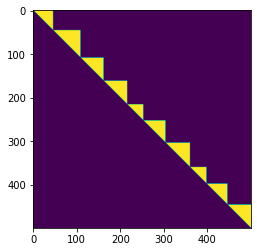

In [18]:
jasmine = same_event*local_mask
jasmine.astype('int')
plt.imshow(jasmine)
jasmine.astype('bool');

In [21]:
print(cc[same_event*local_mask])
print(cc[same_event*local_mask].shape)
print(np.sum(same_event*local_mask))

[0.64231585 0.92893451 0.89258341 ... 0.73921026 0.691506   0.88841593]
(12540,)
12540


In [25]:
print(cc[(~same_event)*local_mask].shape)

(16507,)


In [31]:
within = cc[same_event*local_mask].mean()
print(within)
across = cc[(~same_event)*local_mask].mean()
print(across)

within_across = within - across
print(within_across)
#wVa_results[i,j,b] = within_across

0.698166082391958
-0.07346147670780222
0.7716275590997602


Perform a mini k-sweep on the simulated data.

In [26]:
k_test = [2,3,5,8,10,12,15,18,20]
print(len(k_test))

9


In [27]:
# Create empty list to hold scores
WvA = []

# Data is the same across the k-sweep
cc = np.corrcoef(D.T)

for this_k in k_test:
  # Find the events in this dataset using this k
  ev = EventSegment(this_k)
  ev.fit(D.T)

  # Model's prediction of event for each time point
  events = np.argmax(ev.segments_[0],axis=1)
  max_event_length = stats.mode(events)[1][0]

  # Create a mask to only look at values up to max_event_length
  local_mask = np.zeros(cc.shape, dtype=bool)
  for jazz in range(1,max_event_length):
    local_mask[np.diag(np.ones(cc.shape[0]-jazz, dtype=bool), jazz)] = True

  # Compute within vs across boundary correlations
  same_event = events[:,np.newaxis] == events
  within = cc[same_event*local_mask].mean()
  across = cc[(~same_event)*local_mask].mean()
  within_across = within - across
  WvA.append(within_across)

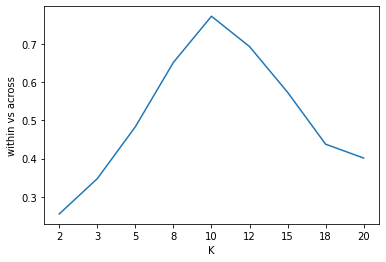

In [30]:
plt.plot(WvA)
plt.xticks(range(len(k_test)),labels=k_test)
plt.xlabel('K')
plt.ylabel('within vs across');

Good - the ground truth is that there are 10 events in the simulated data. We expect the peak of within vs across values in the k-sweep to be at 10, which it is.

# Event segmentation on real data

In [34]:
filepath = 'drive/MyDrive/fMRI_music_data/A1_by_subject_sorted_conds/'
test = np.load(filepath+'A1_sub-103.npy')
print(test.shape)

(516, 1776)


In [35]:
# grab the first run in this data
n_TRs = 148
test_data = test[:,:n_TRs]
print(test_data.shape)

(516, 148)


In [36]:
k_test = [2,3,4,5,8,10,12,15,18,20,24,30,35,40]

# Create empty list to hold scores
WvA = []

# Data is the same across the k-sweep
cc = np.corrcoef(test_data.T)

for this_k in k_test:
  # Find the events in this dataset using this k
  ev = EventSegment(this_k)
  ev.fit(test_data.T)
  print('model with k = %d fit'%this_k)

  # Model's prediction of event for each time point
  events = np.argmax(ev.segments_[0],axis=1)
  max_event_length = stats.mode(events)[1][0]

  # Create a mask to only look at values up to max_event_length
  local_mask = np.zeros(cc.shape, dtype=bool)
  for jazz in range(1,max_event_length):
    local_mask[np.diag(np.ones(cc.shape[0]-jazz, dtype=bool), jazz)] = True

  # Compute within vs across boundary correlations
  same_event = events[:,np.newaxis] == events
  within = cc[same_event*local_mask].mean()
  across = cc[(~same_event)*local_mask].mean()
  within_across = within - across
  WvA.append(within_across)

model with k = 2 fit
model with k = 3 fit
model with k = 4 fit
model with k = 5 fit
model with k = 8 fit
model with k = 10 fit
model with k = 12 fit
model with k = 15 fit
model with k = 18 fit
model with k = 20 fit
model with k = 24 fit
model with k = 30 fit
model with k = 35 fit
model with k = 40 fit


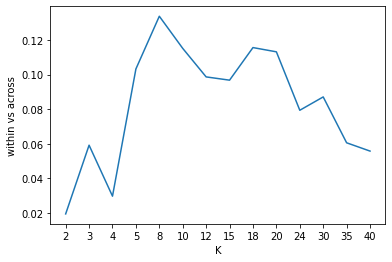

In [37]:
plt.plot(WvA)
plt.xticks(range(len(k_test)),labels=k_test)
plt.xlabel('K')
plt.ylabel('within vs across');

This isn't the most efficient, but k-sweep over entire range from 2 to 40.

In [39]:
k_test = np.arange(2,41)
print(k_test)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [40]:
# Create empty list to hold scores
WvA = []

# Data is the same across the k-sweep
cc = np.corrcoef(test_data.T)

for this_k in k_test:
  # Find the events in this dataset using this k
  ev = EventSegment(this_k)
  ev.fit(test_data.T)
  print('model with k = %d fit'%this_k)

  # Model's prediction of event for each time point
  events = np.argmax(ev.segments_[0],axis=1)
  max_event_length = stats.mode(events)[1][0]

  # Create a mask to only look at values up to max_event_length
  local_mask = np.zeros(cc.shape, dtype=bool)
  for jazz in range(1,max_event_length):
    local_mask[np.diag(np.ones(cc.shape[0]-jazz, dtype=bool), jazz)] = True

  # Compute within vs across boundary correlations
  same_event = events[:,np.newaxis] == events
  within = cc[same_event*local_mask].mean()
  across = cc[(~same_event)*local_mask].mean()
  within_across = within - across
  WvA.append(within_across)

model with k = 2 fit
model with k = 3 fit
model with k = 4 fit
model with k = 5 fit
model with k = 6 fit
model with k = 7 fit
model with k = 8 fit
model with k = 9 fit
model with k = 10 fit
model with k = 11 fit
model with k = 12 fit
model with k = 13 fit
model with k = 14 fit
model with k = 15 fit
model with k = 16 fit
model with k = 17 fit
model with k = 18 fit
model with k = 19 fit
model with k = 20 fit
model with k = 21 fit
model with k = 22 fit
model with k = 23 fit
model with k = 24 fit
model with k = 25 fit
model with k = 26 fit
model with k = 27 fit
model with k = 28 fit
model with k = 29 fit
model with k = 30 fit
model with k = 31 fit
model with k = 32 fit
model with k = 33 fit
model with k = 34 fit
model with k = 35 fit
model with k = 36 fit
model with k = 37 fit
model with k = 38 fit
model with k = 39 fit
model with k = 40 fit


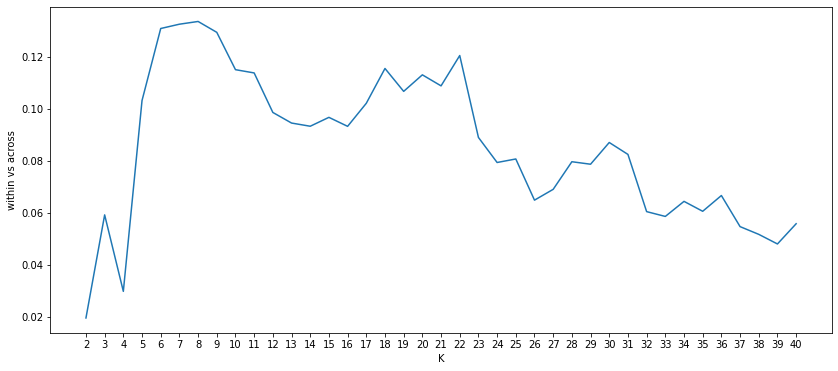

In [44]:
plt.figure(figsize=(14,6))
plt.plot(WvA)
plt.xticks(range(len(k_test)),labels=k_test)
plt.xlabel('K')
plt.ylabel('within vs across');

In [45]:
print(np.argmax(WvA))

6


In [50]:
for i in range(len(WvA)):
  print('%d: %f'%(i+2,WvA[i]))

2: 0.019496
3: 0.059182
4: 0.029743
5: 0.103214
6: 0.130936
7: 0.132595
8: 0.133647
9: 0.129462
10: 0.115087
11: 0.113831
12: 0.098618
13: 0.094540
14: 0.093311
15: 0.096731
16: 0.093270
17: 0.102146
18: 0.115551
19: 0.106738
20: 0.113098
21: 0.108854
22: 0.120536
23: 0.089001
24: 0.079353
25: 0.080709
26: 0.064856
27: 0.069021
28: 0.079647
29: 0.078687
30: 0.087053
31: 0.082463
32: 0.060438
33: 0.058587
34: 0.064387
35: 0.060571
36: 0.066636
37: 0.054665
38: 0.051686
39: 0.047988
40: 0.055774


Rerun the HMM for k = 8 and k = 22 and visualize the HMM boundaries on the TRxTR matrix. The plotting function is borrowed from the BrainIAK tutorial.

In [53]:
import matplotlib.patches as patches

In [51]:
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    ax.imshow(np.corrcoef(data_matrix.T), cmap='viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    # plot the boundaries 
    bounds_aug = np.concatenate(([0],bounds,[n_TRs]))
    for i in range(len(bounds_aug)-1):
        rect = patches.Rectangle(
            (bounds_aug[i],bounds_aug[i]),
            bounds_aug[i+1]-bounds_aug[i],
            bounds_aug[i+1]-bounds_aug[i],
            linewidth=2,edgecolor='w',facecolor='none'
        )
        ax.add_patch(rect)

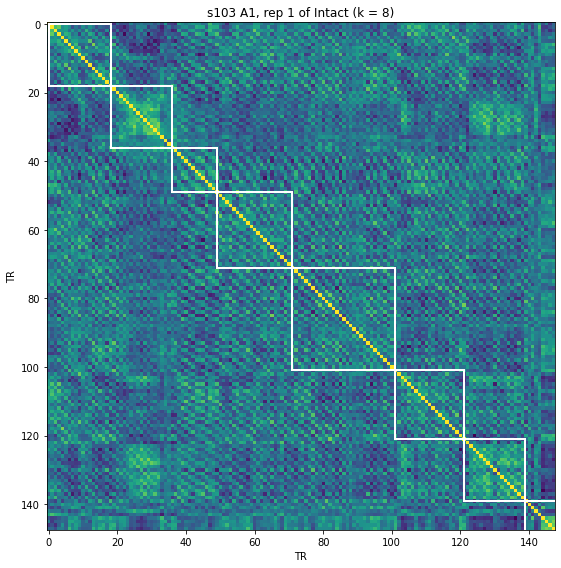

In [55]:
k = 8
ev = EventSegment(k)
ev.fit(test_data.T)
pred_seg = ev.segments_[0]

# extract the boundaries 
bounds = np.where(np.diff(np.argmax(pred_seg, axis=1)))[0]

f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = 's103 A1, rep 1 of Intact (k = %d)'%k
plot_tt_similarity_matrix(ax, test_data, bounds, n_TRs, title_text)
f.tight_layout()

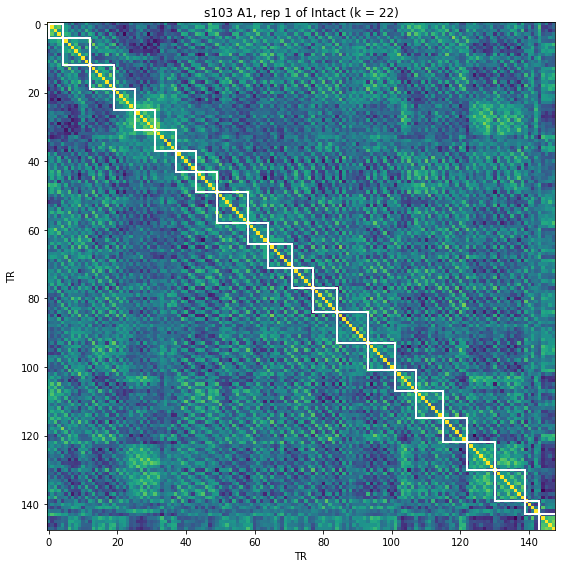

In [56]:
k = 22
ev = EventSegment(k)
ev.fit(test_data.T)
pred_seg = ev.segments_[0]

# extract the boundaries 
bounds = np.where(np.diff(np.argmax(pred_seg, axis=1)))[0]

f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = 's103 A1, rep 1 of Intact (k = %d)'%k
plot_tt_similarity_matrix(ax, test_data, bounds, n_TRs, title_text)
f.tight_layout()